# Quantify "How Good" is the model?
The stopping force varies between different periodic images of the Al structure, even though the environment is identical. We can use that variation to provide a baseline for the accuracy of our machine learning model. 

In [24]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.interpolate import interp1d
from cycler import cycler
import pickle as pkl
import pandas as pd
import numpy as np
import os

## Load in the data needed for this notebook
We'll need the channel data, and the ability to evaluate the ML model on it

In [25]:
channel_data = pd.read_pickle(os.path.join('data', 'channel_data.pkl.gz'))

In [26]:
random_data = pd.read_pickle(os.path.join('data', 'random_data.pkl.gz'))

In [27]:
featurizers = pkl.load(open(os.path.join('..', 'featurizers.pkl'), 'rb'))

In [28]:
model = pkl.load(open('best_model.pkl', 'rb'))

In [29]:
X_cols = featurizers.feature_labels()

Get the lattice spacing

In [30]:
start_frame = pkl.load(open(os.path.join('..', 'al_starting_frame.pkl'), 'rb'))

In [31]:
lat_spacing = start_frame.cell[0, 0] / 4

## Make an interpolator for the channel data
The steps in the each repeat of the structure don't line up perfectly

In [9]:
force_inter = interp1d(channel_data['displacement'], channel_data['force'], 'cubic')

Show that it works

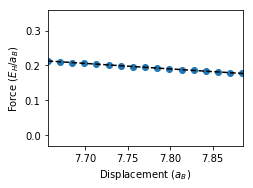

In [10]:
fig, ax = plt.subplots()

disps = np.linspace(0, lat_spacing, 2048) + lat_spacing

ax.scatter(channel_data['displacement'], channel_data['force'])
ax.plot(disps, force_inter(disps), 'k--')

ax.set_xlim(lat_spacing, lat_spacing * 1.03)

ax.set_xlabel('Displacement ($a_B$)')
ax.set_ylabel('Force ($E_H / a_B$)')

fig.set_size_inches(3.5, 2.5)

*Finding*: It interpolates between points without much trouble

## Identify the repeated portions of the crystal
Plot the 4 repeated patterns over the same part of the crystal. We only consider the 2$^{nd}$ and 3<sup>rd</sup> repititions of the pattern, as these are free from the initial transients and projectile interacting with its wake

Find the repeated portion

In [32]:
spacings = np.arange(lat_spacing, lat_spacing * 3, lat_spacing / 2)

In [33]:
subsets = [channel_data.query('displacement > {} and displacement <= {}'.format(s, s + 0.5 * lat_spacing))
          for s in spacings]

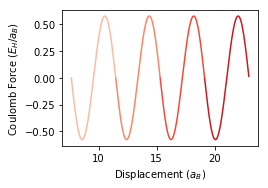

In [34]:
fig, ax = plt.subplots()

cmap = cm.get_cmap('Reds')
ax.set_prop_cycle(cycler('color', [cmap(x) for x in np.linspace(0.25,0.75,len(subsets))]))
for subset in subsets:
    ax.plot(subset['displacement'], subset['ion-ion repulsion'])
    
ax.set_xlabel('Displacement ($a_B$)')
ax.set_ylabel('Coulomb Force ($E_H / a_B$)')
    
fig.set_size_inches(3.5, 2.5)

*Finding*: In the middle part of the channel data, the pattern repeats 4 times

## Measure differences in TD-DFT over different repeats and ML
To quantify, we're going to compute the mean absolute deviation from the mean of all 4 repeats

Determine the "mean" trajectory

In [35]:
eval_points = subsets[0]['displacement'] - subsets[0]['displacement'].min()

In [36]:
mean_traj = np.mean([force_inter(eval_points + subset['displacement'].min()) for subset in subsets], axis=0)

Plot the differences between TD-DFT and compare to ML

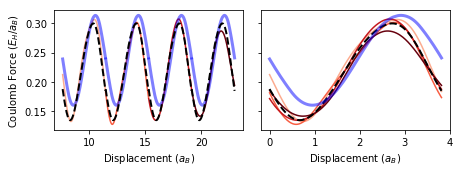

In [37]:
fig, axs = plt.subplots(1, 2, sharey=True)

for ax in axs:
    ax.set_prop_cycle(cycler('color', [cmap(x) for x in np.linspace(0.3,1,len(subsets))]))
    
# Plot all the trajectories
for subset in subsets:
    axs[0].plot(subset['displacement'], subset['force'])
    axs[0].plot(subset['displacement'], model.predict(subset[X_cols]), lw=3, alpha=0.5, color='blue')
    axs[0].plot(subset['displacement'], mean_traj, 'k--', lw=2)
    axs[1].plot(subset['displacement'] - subset['displacement'].min(), subset['force'])
    
# Plot the mean and the ML
axs[1].plot(subset['displacement'] - subset['displacement'].min(), mean_traj, 'k--', lw=2)
axs[1].plot(subset['displacement'] - subset['displacement'].min(), model.predict(subset[X_cols]), lw=3, alpha=0.5, color='blue')
    
axs[0].set_xlabel('Displacement ($a_B$)')
axs[1].set_xlabel('Displacement ($a_B$)')
axs[0].set_ylabel('Coulomb Force ($E_H / a_B$)')
    
fig.set_size_inches(6.5, 2.5)
fig.tight_layout()

*Finding*: The ML model is definitely different, it overestimates the minimum and is a little bit out-of-phase. It is clearly the outlier for the dataset

In [38]:
tddft_var = np.mean(np.abs([force_inter(eval_points + subset['displacement'].min()) - mean_traj for subset in subsets]))

In [39]:
print('Mean absolute deviation of TD-DFT: {:.2e} E_H/a_B'.format(tddft_var))

Mean absolute deviation of TD-DFT: 6.32e-03 E_H/a_B


Compare this to ML

In [40]:
ml_var = np.abs([subset['force'] - model.predict(subset[X_cols]) for subset in subsets]).mean()

In [43]:
print('Mean absolute error of TD-DFT: {:.2e} E_H/a_B ({:.1f}x larger than TD-DFT variation)'.format(ml_var, ml_var / tddft_var))

Mean absolute error of TD-DFT: 2.52e-02 E_H/a_B (4.0x larger than TD-DFT variation)


Compare to "no ML", just guess average stopping power of random trajectory

In [21]:
noml_force = random_data.query('initial == False')['force'].mean()

In [22]:
noml_var = np.abs([subset['force'] - noml_force]).mean()

In [48]:
print('Mean absolute error of "no ML" model: {:.2e} E_H/a_B ({:.1f}x larger than ML varation)'.format(noml_var, noml_var / ml_var))

Mean absolute error of "no ML" model: 4.99e-02 E_H/a_B (2.0x larger than ML varation)
